In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Load your dataset
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')
# Ensure your dataset has 'source' and 'target' columns
train_source_texts = train_data['indonesian'].values
train_target_texts = train_data['english'].values

val_source_texts = val_data['indonesian'].values
val_target_texts = val_data['english'].values

test_source_texts = test_data['indonesian'].values
test_target_texts = test_data['english'].values

In [3]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [49]:
print(len(train_target_sequences[1]))
print(len(val_target_sequences[0]))

20
19


In [4]:
# Pad sequences to ensure uniform input size
max_source_length = 77
max_target_length = 77   #to include EOS or shifted tokens
X_train_source = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
X_train_target = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

X_val_source = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
X_val_target = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

X_test_source = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
X_test_target = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')


In [5]:
# Shift target sequences for teacher forcing
train_target_sequences_shifted = np.zeros_like(X_train_target)
train_target_sequences_shifted[:, :-1] = X_train_target[:, 1:]

# One-hot encode target sequences
y_train = X_train_target[:, 1:]
y_train = to_categorical(train_target_sequences_shifted, num_classes=target_vocab_size)

val_target_sequences_shifted = np.zeros_like(X_val_target)
val_target_sequences_shifted[:, :-1] = X_val_target[:, 1:]

y_val = X_val_target[:, 1:]  # Exclude the first token
y_val = to_categorical(val_target_sequences_shifted, num_classes=target_vocab_size)

In [52]:
# Check dimensions
print(f'X_train_source shape: {X_train_source.shape}')
print(f'X_val_source shape: {X_val_source.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train_source shape: (500, 77)
X_val_source shape: (100, 77)
y_train shape: (500, 77, 2863)
y_val shape: (100, 77, 2863)


In [6]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Hyperparameters
EMBEDDING_SIZE = 256       # Size of the embedding layer
RNN_UNITS = 256            # Number of RNN units
max_source_length = 77    # Max length of source sequences
max_target_length = 77    # Max length of target sequences

# Encoder Model
encoder_inputs = Input(shape=(max_source_length,))
encoder_embedding_layer = Embedding(source_vocab_size, EMBEDDING_SIZE)(encoder_inputs)
encoder = SimpleRNN(RNN_UNITS, return_state=True)
encoder_outputs, h = encoder(encoder_embedding_layer)
encoder_states = h

# Decoder Model
decoder_inputs = Input(shape=(1,))  # Input shape for a single time step
decoder_embedding_layer = Embedding(target_vocab_size, EMBEDDING_SIZE)(decoder_inputs)
decoder = SimpleRNN(RNN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder(decoder_embedding_layer, initial_state=encoder_states)

# Output Layer
output_dense_layer = Dense(target_vocab_size, activation='softmax')
outputs = output_dense_layer(decoder_outputs)

# Complete Seq2Seq Model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [54]:
print(decoder_outputs.shape)
print(outputs.shape)

(None, 1, 256)
(None, 1, 2863)


In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Add model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'mt_best_val_accuracy_{val_accuracy:.4f}.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='max',  # Minimize validation loss
    verbose=1  # Print a message when the model is saved
)

In [56]:
# Fit the model with the ModelCheckpoint callback
history = model.fit([X_train_source, X_train_target], y_train,
                    epochs=50, batch_size=64,
                    validation_data=([X_val_source, X_val_target], y_val),
                    callbacks=[model_checkpoint])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4129 - loss: 6.6823
Epoch 1: val_accuracy improved from -inf to 0.70753, saving model to mt_best_val_accuracy_0.7075.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4278 - loss: 6.5497 - val_accuracy: 0.7075 - val_loss: 2.7304
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6461 - loss: 3.0229
Epoch 2: val_accuracy did not improve from 0.70753
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6451 - loss: 3.0191 - val_accuracy: 0.7075 - val_loss: 2.2465
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6445 - loss: 2.6707
Epoch 3: val_accuracy did not improve from 0.70753
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.6437 - loss: 2.6713 - val_accuracy: 0.7075 - val_loss: 2.0226
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6339 - loss: 2.5396
Epoch 4: val_accuracy did not improve from 0.70753
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6343 - loss: 2.5350 - val_accu

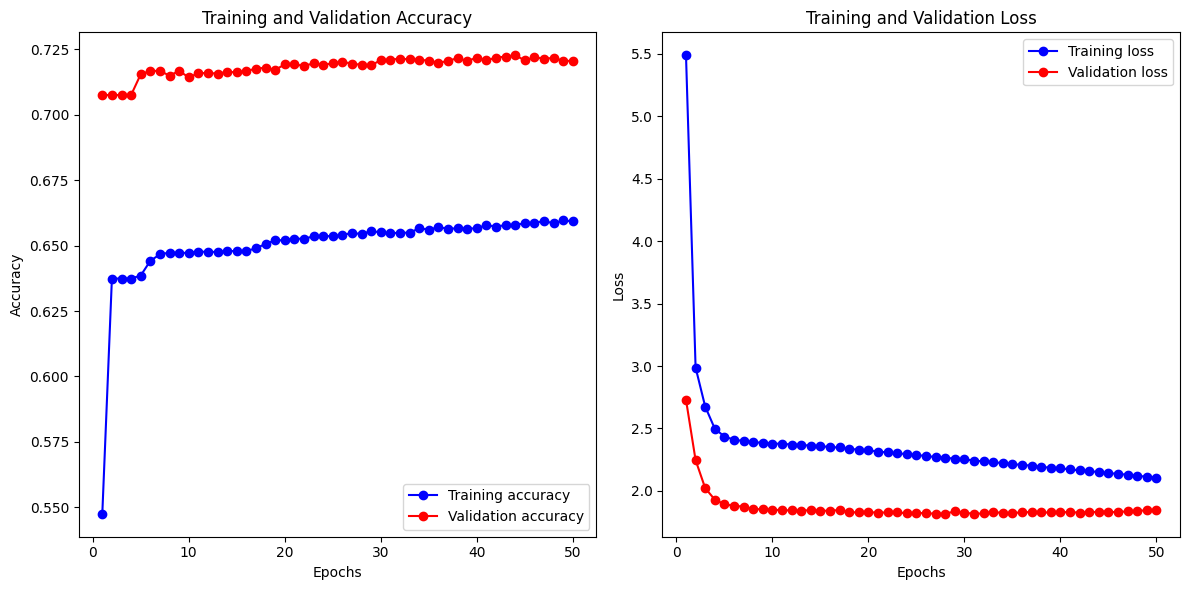

In [57]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the history object
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [58]:
# Evaluation on the test set
test_target_sequences_shifted = np.zeros_like(X_test_target)
test_target_sequences_shifted[:, :-1] = X_test_target[:, 1:]
y_test = to_categorical(test_target_sequences_shifted, num_classes=target_vocab_size)
test_loss, test_accuracy = model.evaluate([X_test_source, X_test_target], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.6923 - loss: 2.0123
Test Accuracy: 0.7039


In [12]:
word2idx_inputs = source_tokenizer.word_index
word2idx_outputs = target_tokenizer.word_index

# Check the current max index in word2idx_outputs
max_index = max(word2idx_outputs.values())

# Add the <sos> token with the next available index
word2idx_outputs['<sos>'] = max_index + 1

# Optional: Ensure idx2word_target is updated accordingly
idx2word_target = {v: k for k, v in word2idx_outputs.items()}


idx2word_input = {v:k for k, v in word2idx_inputs.items()}

In [11]:
word2idx_outputs

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'is': 5,
 'of': 6,
 'i': 7,
 'for': 8,
 'was': 9,
 'in': 10,
 'it': 11,
 'with': 12,
 'that': 13,
 'my': 14,
 'this': 15,
 'food': 16,
 'just': 17,
 'you': 18,
 'place': 19,
 'also': 20,
 'so': 21,
 'we': 22,
 'but': 23,
 "it's": 24,
 'are': 25,
 'here': 26,
 'from': 27,
 'good': 28,
 'at': 29,
 'not': 30,
 'as': 31,
 'all': 32,
 'on': 33,
 'price': 34,
 'be': 35,
 'when': 36,
 'because': 37,
 'really': 38,
 'there': 39,
 'can': 40,
 'has': 41,
 'out': 42,
 'too': 43,
 'were': 44,
 'time': 45,
 'have': 46,
 'if': 47,
 'even': 48,
 'they': 49,
 'menu': 50,
 'like': 51,
 'very': 52,
 'great': 53,
 'or': 54,
 'more': 55,
 'restaurant': 56,
 'by': 57,
 'fried': 58,
 'taste': 59,
 'pretty': 60,
 'your': 61,
 'me': 62,
 'delicious': 63,
 'lot': 64,
 'people': 65,
 'about': 66,
 'service': 67,
 'family': 68,
 'our': 69,
 'resto': 70,
 'had': 71,
 'one': 72,
 'no': 73,
 'got': 74,
 'an': 75,
 "there's": 76,
 'perfect': 77,
 'eating': 78,
 'go': 79,
 'e

In [16]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Hyperparameters (same as training)
EMBEDDING_SIZE = 256       # Size of the embedding layer
RNN_UNITS = 256            # Number of RNN units
max_source_length = 77      # Max length of source sequences
max_target_length = 77      # Max length of target sequences

# --- Encoder Inference Model ---

# Encoder inputs (same shape as training)
encoder_inputs = Input(shape=(max_source_length,))
encoder_embedding_layer = Embedding(source_vocab_size, EMBEDDING_SIZE)(encoder_inputs)
encoder_rnn = SimpleRNN(RNN_UNITS, return_state=True)

# Get encoder's hidden state
encoder_outputs, encoder_state_h = encoder_rnn(encoder_embedding_layer)
encoder_model = Model(encoder_inputs, encoder_state_h)  # Encoder model returns hidden state

# --- Decoder Inference Model ---

# Decoder inputs (single time step input for inference)
decoder_inputs_single = Input(shape=(1,))
decoder_state_input_h = Input(shape=(RNN_UNITS,))  # Hidden state input for inference

# Embedding layer
decoder_embedding_layer = Embedding(target_vocab_size, EMBEDDING_SIZE)(decoder_inputs_single)

# RNN layer (with previous hidden state as initial state)
decoder_rnn = SimpleRNN(RNN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_h = decoder_rnn(decoder_embedding_layer, initial_state=decoder_state_input_h)

# Dense softmax layer to predict the next token
output_dense_layer = Dense(target_vocab_size, activation='softmax')
decoder_outputs = output_dense_layer(decoder_outputs)

# Define the decoder inference model, which outputs predicted token and new hidden state
decoder_model = Model(
    [decoder_inputs_single, decoder_state_input_h],
    [decoder_outputs, decoder_state_h]
)

# --- Function to Generate Translations ---

def translate_sentence(input_seq):
    # Encode the input sequence to get the initial hidden state
    state_value = encoder_model.predict(input_seq)

    # Initialize the target sequence with the start token <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']  # Or another start token

    output_sentence = []
    stop_condition = False
    while not stop_condition:
        # Predict the next token and the next hidden state
        output_tokens, h = decoder_model.predict([target_seq, state_value])

        # Get the index of the predicted token
        predicted_token_index = np.argmax(output_tokens[0, -1, :])
        predicted_word = idx2word_target.get(predicted_token_index, '')

        # Append predicted word to the output sentence
        if predicted_word == '<eos>' or len(output_sentence) >= max_target_length:
            stop_condition = True
        else:
            output_sentence.append(predicted_word)

        # Update the target sequence (current predicted token becomes next input)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_token_index

        # Update the hidden state for the next time step
        state_value = h

    return ' '.join(output_sentence)

# Test the translation with an example input sentence
input_seq = X_test_source[0:1]  # Example input
translated_sentence = translate_sentence(input_seq)
# Assuming X_test_source is a numpy array or a list containing your test sentences
# You may want to iterate through the input sequences and print them

for i, input_sentence in enumerate(input_seq):
    # If the input is tokenized (numerical indices), you may want to reverse it to words
    input_sentence_words = ' '.join(idx2word_input.get(token, '') for token in input_sentence if token != 0)  # Assuming 0 is padding
    print(f'Input Sentence {i + 1}: {input_sentence_words}')

print('Predicted Translation:', translated_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━